# Visualization of the uncertainty maps

In [6]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Union

from assets.dicom_utils import resample_to_reference
from assets.uncertainty_quantification import apply_percentile_threshold
from assets.image_operations import apply_gaussian_blur_3d, adaptive_clip

#################
# Have you first generated the uncertainty maps with the `08_generate_uncertainty_maps.ipynb` script?
#################


roots = {
    'kspace':            Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':      Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs': Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_recons_gau':     Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_recons_gau':     Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'R3_recons_lxo':     Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/lxo/recons_{3}x"),
    'R6_recons_lxo':     Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/lxo/recons_{6}x"),
    'db_fpath_old':      Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':      Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
    'figures':           Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/figures"),
}

# Check if all root paths exist
for root in roots.values():
    if not root.exists():
        raise FileNotFoundError(f"Root path {root} does not exist. Please check the paths.")

debug                = True
do_adaptive_clipping = True
do_blurring          = True
acc_factors          = [3, 6] # Define the set of acceleration factors we care about.
decimals             = 4      # Number of decimals to round to

# All patient IDs to consider for Uncertainty Quantification
pat_ids = [
        # '0003_ANON5046358',
        # '0004_ANON9616598',
        # '0005_ANON8290811',
        # '0006_ANON2379607',
        # '0007_ANON1586301',     # with lesions I think for testing.
        # '0008_ANON8890538',
        # '0010_ANON7748752',
        # '0011_ANON1102778',
        # '0012_ANON4982869',
        # '0013_ANON7362087',
        # '0014_ANON3951049',
        # '0015_ANON9844606',
        # '0018_ANON9843837',
        # '0019_ANON7657657',
        # '0020_ANON1562419',
        # '0021_ANON4277586',
        # '0023_ANON6964611',
        # '0024_ANON7992094',
        # '0026_ANON3620419',
        # '0027_ANON9724912',   # here is 20
        # '0028_ANON3394777',
        # '0029_ANON7189994',
        # '0030_ANON3397001',
        # '0031_ANON9141039',
        # '0032_ANON7649583',
        # '0033_ANON9728185',
        # '0035_ANON3474225',
        # '0036_ANON0282755',
        # '0037_ANON0369080',
        # '0039_ANON0604912',
        # '0042_ANON9423619',
        # '0043_ANON7041133',
        # '0044_ANON8232550',
        # '0045_ANON2563804',
        # '0047_ANON3613611',
        # '0048_ANON6365688',
        # '0049_ANON9783006',
        # '0051_ANON1327674',
        # '0052_ANON9710044',
        # '0053_ANON5517301',
        # '0055_ANON3357872',
        # '0056_ANON2124757',
        # '0057_ANON1070291',
        # '0058_ANON9719981',
        # '0059_ANON7955208',
        # '0061_ANON7642254',
        # '0062_ANON0319974',
        # '0063_ANON9972960',
        # '0064_ANON0282398',
        # '0067_ANON0913099',
        # '0068_ANON7978458',
        # '0069_ANON9840567',
        # '0070_ANON5223499',
        # '0071_ANON9806291',
        # '0073_ANON5954143',
        # '0075_ANON5895496',
        # '0076_ANON3983890',
        # '0077_ANON8634437',
        # '0078_ANON6883869',
        # '0079_ANON8828023',
        # '0080_ANON4499321',
        # '0081_ANON9763928',
        # '0082_ANON6073234',
        # '0083_ANON9898497',
        # '0084_ANON6141178',
        # '0085_ANON4535412',
        # '0086_ANON8511628',
        # '0087_ANON9534873',
        # '0088_ANON9892116',
        # '0089_ANON9786899',
        # '0090_ANON0891692',
        # '0092_ANON9941969',
        # '0093_ANON9728761',
        # '0094_ANON8024204',
        # '0095_ANON4189062',
        # '0097_ANON5642073',
        # '0103_ANON8583296',
        # '0104_ANON7748630',
        # '0105_ANON9883201',
        # '0107_ANON4035085',
        # '0108_ANON0424679',
        # '0109_ANON9816976',
        # '0110_ANON8266491',
        # '0111_ANON9310466',
        # '0112_ANON3210850',
        # '0113_ANON9665113',
        # '0115_ANON0400743',
        # '0116_ANON9223478',
        ##'0118_ANON7141024',       We skip this patient because the LXO method does not seem to work for it.
        '0119_ANON3865800',
        '0120_ANON7275574',
        '0121_ANON9629161',
        '0123_ANON7265874',
        '0124_ANON8610762',
        '0125_ANON0272089',
        '0126_ANON4747182',
        '0127_ANON8023509',
        '0128_ANON8627051',
        '0129_ANON5344332',
        '0135_ANON9879440',
        '0136_ANON8096961',
        '0137_ANON8035619',
        '0138_ANON1747790',
        '0139_ANON2666319',
        '0140_ANON0899488',
        '0141_ANON8018038',
        '0142_ANON7090827',
        '0143_ANON9752849',
        '0144_ANON2255419',
        '0145_ANON0335209',
        '0146_ANON7414571',
        '0148_ANON9604223',
        '0149_ANON4712664',
        '0150_ANON5824292',
        '0152_ANON2411221',
        '0153_ANON5958718',
        '0155_ANON7828652',
        '0157_ANON9873056',
        '0159_ANON9720717',
        '0160_ANON3504149'
    ]

## So what do we want to see?

The goals is to see if the uncertainty map is correlated with the absoluate error map.
Especially in lesion locations.

We will first explore the following figure:
```
| R1          |      R3           |      R6          |

| R1 lesions  | Abs Error R3      | Abs Error R6     |

| Prost. seg. |   UQ map R3 gaus  |   UQ map R6 gaus |

| Prost. seg. |   UQ map R3 lxo   |   UQ map R6 lxo  |
```


In [7]:
def _get_nonzero_slice_indexes(arr: np.ndarray) -> List[int]:
    """
    Get the indexes of all slices in a 3D array where the sum of the slice is not zero.

    Args:
        arr (np.ndarray): 3D array with shape (slices, rows, cols).

    Returns:
        List[int]: List of indexes of non-zero slices.
    """
    # Compute the sum of each slice along the (rows, cols) dimensions
    slice_sums = np.sum(arr, axis=(1, 2))
    
    # Get the indexes of slices where the sum is not zero
    nonzero_indexes = [i for i, s in enumerate(slice_sums) if s != 0]
    return nonzero_indexes


def _get_middle_index_of_nonzero_slices(arr: np.ndarray) -> int:
    """
    Get the middle index of all non-zero slices in a 3D array.

    Args:
        arr (np.ndarray): 3D array with shape (slices, rows, cols).

    Returns:
        int: Middle index of non-zero slices.
    """
    # Get the indexes of non-zero slices
    nonzero_indexes = _get_nonzero_slice_indexes(arr)
    
    # If no non-zero slices exist, return -1 or raise an exception
    if not nonzero_indexes:
        raise ValueError("No non-zero slices found in the array.")
    
    # Calculate the middle index
    middle_index = nonzero_indexes[len(nonzero_indexes) // 2]
    return middle_index



def plot_uq_vs_abs_grid(
    pat_id: str,
    slice_idx: int,
    roots: Dict[Union[str, int], Path],
    do_adaptive_clipping: bool          = False,
    do_blurring: bool                   = False,
    do_show_now: bool                   = False,
):
    def get_combined_rois_array(pat_root: Path, r1_ref_image: sitk.Image, r1_arr: np.ndarray) -> Tuple[np.ndarray, List[int]]:
        roi_fpaths = list(pat_root.glob("*_roi_*.mha"))
        roi_arrs_combined = np.zeros_like(r1_arr)
        if len(roi_fpaths) == 0:
            print(f"\tNo ROIs found in {pat_root.name}.")
            return roi_arrs_combined, []
        for roi_fpath in roi_fpaths:
            roi_img = sitk.ReadImage(str(roi_fpath))
            roi_img_resampled = resample_to_reference(roi_img, r1_ref_image)
            roi_arr = sitk.GetArrayFromImage(roi_img_resampled)
            roi_arrs_combined += roi_arr
        slice_idxs_lesion = [i for i in range(len(roi_arrs_combined)) if np.sum(roi_arrs_combined[i]) > 0]
        print(f"\tCombined ROI {roi_fpath.name} has {len(slice_idxs_lesion)} slices with lesions. With idxs: {slice_idxs_lesion}")
        return roi_arrs_combined, slice_idxs_lesion

    pat_root          = roots['reader_study'] / pat_id
    r1_img            = sitk.ReadImage(str(pat_root / f"{pat_id}_rss_target_dcml.mha"))
    r1_arr            = sitk.GetArrayFromImage(r1_img)
    roi_arr, les_idxs = get_combined_rois_array(pat_root, r1_img, r1_arr)
    r1_empty_arr      = np.zeros_like(r1_arr)

    prostate_seg_root = roots['reader_study_segs'] / f"{pat_id}_mlseg_total_mr.nii.gz"
    prost_seg_arr     = sitk.GetArrayFromImage(sitk.ReadImage(str(prostate_seg_root))) # so this is a segmentation of many multi-label anatomical structures, where are interested in where it is the prostate=17
    prost_seg_arr     = np.where(prost_seg_arr == 17, 1, 0) # this is the prostate segmentation

    r3_arr            = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R3_recon_dcml.mha")))
    r3_abs_error_arr  = np.abs(r1_arr - r3_arr)
    r3_uq_map_arr_gau = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R3_recons_gau"] / pat_id / f"uq_map_R3_gaussian.nii.gz")))
    r3_uq_map_arr_lxo = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R3_recons_lxo"] / pat_id / f"uq_map_R3_lxo.nii.gz")))
    # r3_uq_thr         = apply_percentile_threshold(r3_uq_map_arr, percentile=perc_thr, debug=False)

    r6_arr            = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R6_recon_dcml.mha")))
    r6_abs_error_arr  = np.abs(r1_arr - r6_arr)
    r6_uq_map_arr_gau = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_recons_gau"] / pat_id / f"uq_map_R6_gaussian.nii.gz")))
    r6_uq_map_arr_lxo = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_recons_lxo"] / pat_id / f"uq_map_R6_lxo.nii.gz")))
    # r6_uq_thr         = apply_percentile_threshold(r6_uq_map_arr, percentile=perc_thr, debug=False)

    if do_blurring:
        r3_abs_error_arr  = apply_gaussian_blur_3d(r3_abs_error_arr, sigma_xy=1.0, sigma_z=0.0)
        r3_uq_map_arr_gau = apply_gaussian_blur_3d(r3_uq_map_arr_gau, sigma_xy=1.0, sigma_z=0.0)
        r3_uq_map_arr_lxo = apply_gaussian_blur_3d(r3_uq_map_arr_lxo, sigma_xy=1.0, sigma_z=0.0)
        
        r6_abs_error_arr  = apply_gaussian_blur_3d(r6_abs_error_arr, sigma_xy=1.0, sigma_z=0.0)
        r6_uq_map_arr_gau = apply_gaussian_blur_3d(r6_uq_map_arr_gau, sigma_xy=1.0, sigma_z=0.0)
        r6_uq_map_arr_lxo = apply_gaussian_blur_3d(r6_uq_map_arr_lxo, sigma_xy=1.0, sigma_z=0.0)

    if do_adaptive_clipping:
        r1_arr = adaptive_clip(r1_arr)
        r3_arr = adaptive_clip(r3_arr)
        r6_arr = adaptive_clip(r6_arr)

    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    seq_id = pat_id.split('_')[0]

    grid = [
        [r1_arr,        r3_arr,            r6_arr],
        [roi_arr,       r3_abs_error_arr,  r6_abs_error_arr],
        [prost_seg_arr, r3_uq_map_arr_gau, r6_uq_map_arr_gau],
        [prost_seg_arr, r3_uq_map_arr_lxo, r6_uq_map_arr_lxo],
    ]
    titles = [
        [f"R=1: {seq_id}",  f"R3: {seq_id}",          f"R6: {seq_id}"],
        [f"R=1 lesions",    f"R3: Absolute error",    f"R6: Absolute error"],
        ["Prostate seg",    f"R3: UQ (gaussian) map", f"R6: UQ (gaussian) map"],
        ["Prostate seg",    f"R3: UQ (lxo) map",      f"R6: UQ (lxo) map"],
    ]

    # 1. Get the middle index of non-zero slices in the prostate segmentation array
    slice_idx = _get_middle_index_of_nonzero_slices(prost_seg_arr)
    print("Middle index of non-zero slices in prostate segmentation:", slice_idx)

    # 2. If there are no lesions, use the slice index provided. (More important than prostate segmentation, lesion should be in it anyway)
    slice_idx = slice_idx if len(les_idxs) == 0 else les_idxs[0]
    print(f"Using slice index {slice_idx} for patient {pat_id}")

    for i in range(4):
        for j in range(3):
            axs[i, j].imshow(grid[i][j][slice_idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].text(0.05, 0.95, f"{titles[i][j]} slice {slice_idx}", color='red', fontsize=12, transform=axs[i, j].transAxes, va='top')

    plt.tight_layout(pad=0)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)

    roots['figures'].mkdir(parents=True, exist_ok=True)
    save_path = roots['figures'] / f"{pat_id}_UQ_vs_ABS_slice{slice_idx}_R1_R3_R6.png"
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show() if do_show_now else None
    plt.close(fig)
    print(f"Figure saved to {save_path}")



###############################################
# Main execution
###############################################
if True:
    for pat_id in pat_ids:
        plot_uq_vs_abs_grid(
            pat_id               = pat_id,
            slice_idx            = 10,
            roots                = roots,
            do_adaptive_clipping = do_adaptive_clipping,
            do_blurring          = do_blurring,
            do_show_now          = False,
        )


	No ROIs found in 0119_ANON3865800.
Middle index of non-zero slices in prostate segmentation: 19
Using slice index 19 for patient 0119_ANON3865800
Figure saved to /scratch/hb-pca-rad/projects/04_uncertainty_quantification/figures/0119_ANON3865800_UQ_vs_ABS_slice19_R1_R3_R6.png
	No ROIs found in 0120_ANON7275574.
Middle index of non-zero slices in prostate segmentation: 19
Using slice index 19 for patient 0120_ANON7275574
Figure saved to /scratch/hb-pca-rad/projects/04_uncertainty_quantification/figures/0120_ANON7275574_UQ_vs_ABS_slice19_R1_R3_R6.png
	No ROIs found in 0121_ANON9629161.
Middle index of non-zero slices in prostate segmentation: 13
Using slice index 13 for patient 0121_ANON9629161
Figure saved to /scratch/hb-pca-rad/projects/04_uncertainty_quantification/figures/0121_ANON9629161_UQ_vs_ABS_slice13_R1_R3_R6.png
	No ROIs found in 0123_ANON7265874.
Middle index of non-zero slices in prostate segmentation: 12
Using slice index 12 for patient 0123_ANON7265874
Figure saved to /sc

	Combined ROI 0007_ANON1586301_roi_1_2.mha has 3 slices with lesions. With idxs: [8, 9, 10]
Using slice index 8 for patient 0007_ANON1586301


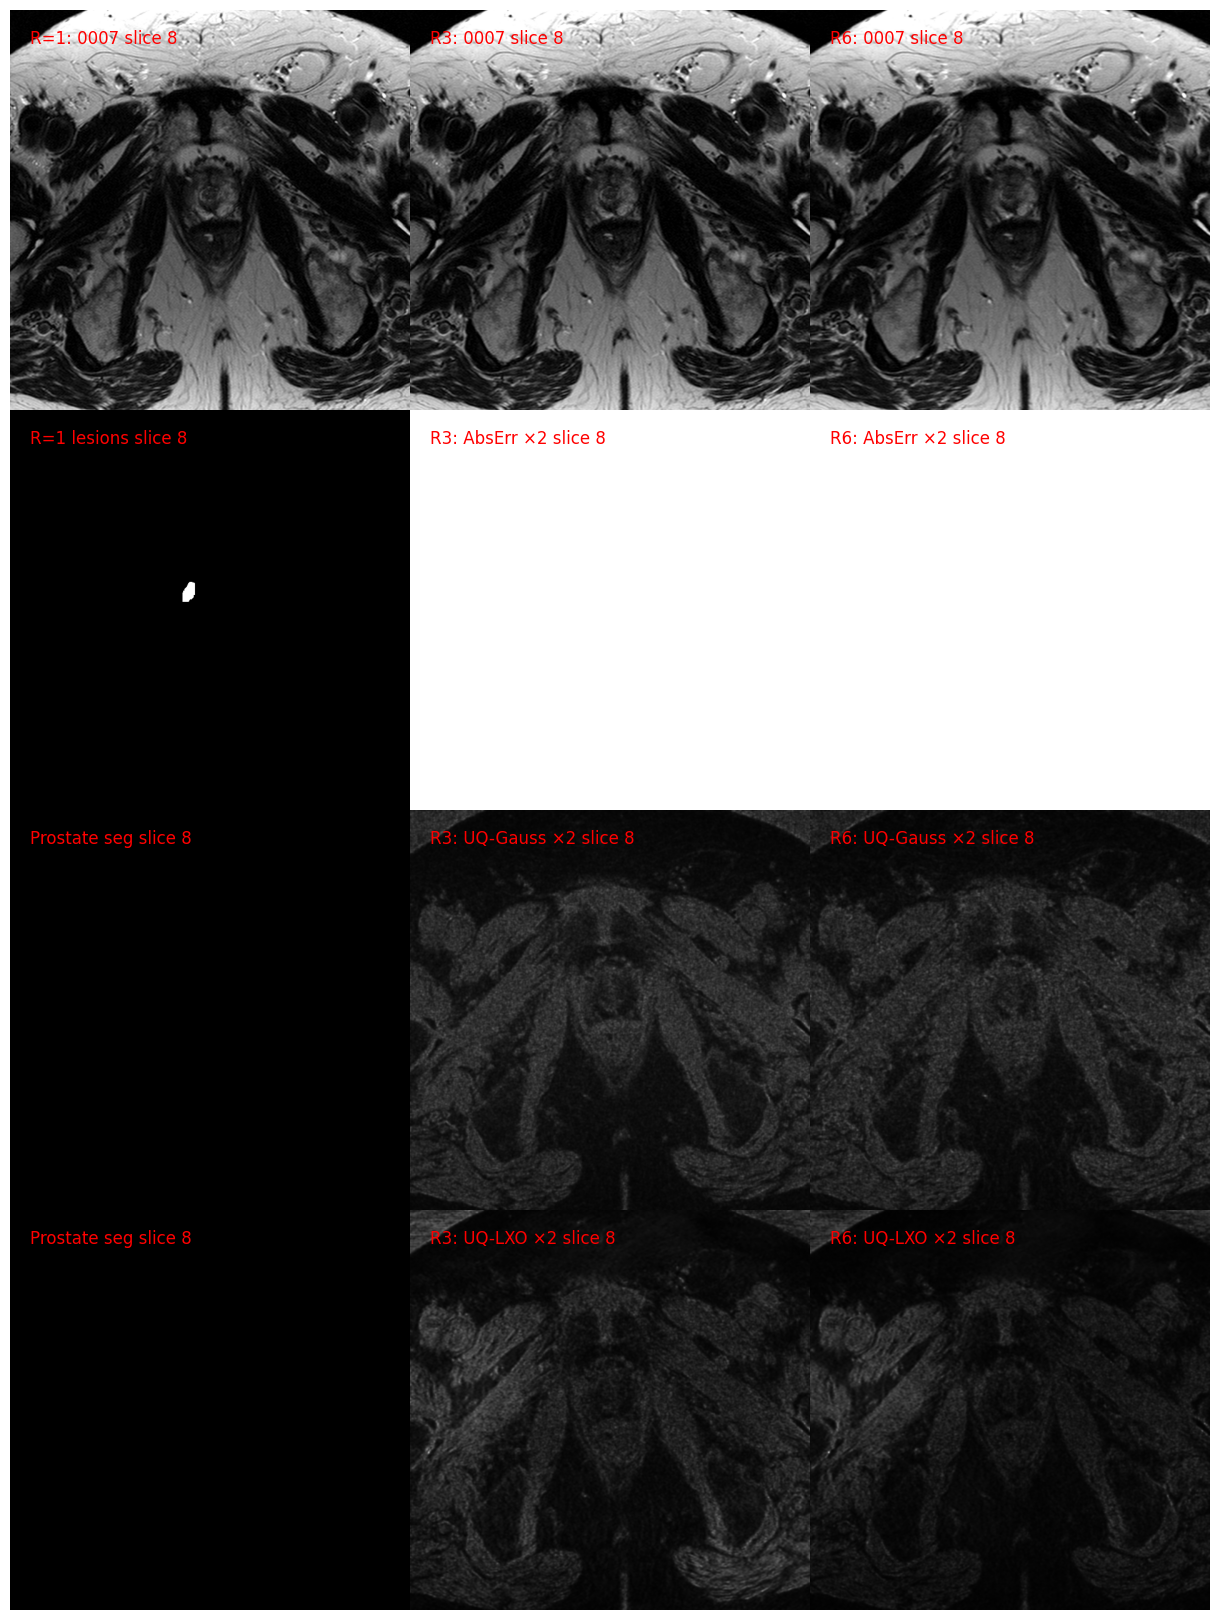

Figure saved to /scratch/hb-pca-rad/projects/04_uncertainty_quantification/figures/0007_ANON1586301_UQ_vs_ABS_slice8_R1_R3_R6.png


In [26]:
def _get_nonzero_slice_indexes(arr: np.ndarray) -> List[int]:
    """
    Get the indexes of all slices in a 3D array where the sum of the slice is not zero.

    Args:
        arr (np.ndarray): 3D array with shape (slices, rows, cols).

    Returns:
        List[int]: List of indexes of non-zero slices.
    """
    # Compute the sum of each slice along the (rows, cols) dimensions
    slice_sums = np.sum(arr, axis=(1, 2))
    
    # Get the indexes of slices where the sum is not zero
    nonzero_indexes = [i for i, s in enumerate(slice_sums) if s != 0]
    return nonzero_indexes


def _get_middle_index_of_nonzero_slices(arr: np.ndarray) -> int:
    """
    Get the middle index of all non-zero slices in a 3D array.

    Args:
        arr (np.ndarray): 3D array with shape (slices, rows, cols).

    Returns:
        int: Middle index of non-zero slices.
    """
    # Get the indexes of non-zero slices
    nonzero_indexes = _get_nonzero_slice_indexes(arr)
    
    # If no non-zero slices exist, return -1 or raise an exception
    if not nonzero_indexes:
        raise ValueError("No non-zero slices found in the array.")
    
    # Calculate the middle index
    middle_index = nonzero_indexes[len(nonzero_indexes) // 2]
    return middle_index



def plot_uq_vs_abs_grid(
    pat_id: str,
    slice_idx: int,
    roots: Dict[Union[str, int], Path],
    do_adaptive_clipping: bool = False,
    do_blurring: bool = False,
    do_show_now: bool = False,
    abs_error_scale: float = 1.0,
    uq_scale: float = 1.0,
):
    def get_combined_rois_array(pat_root: Path, r1_ref_image: sitk.Image, r1_arr: np.ndarray) -> Tuple[np.ndarray, List[int]]:
        roi_fpaths = list(pat_root.glob("*_roi_*.mha"))
        roi_arrs_combined = np.zeros_like(r1_arr)
        if not roi_fpaths:
            print(f"\tNo ROIs found in {pat_root.name}.")
            return roi_arrs_combined, []
        for roi_fpath in roi_fpaths:
            roi_img = sitk.ReadImage(str(roi_fpath))
            roi_img_resampled = resample_to_reference(roi_img, r1_ref_image)
            roi_arr = sitk.GetArrayFromImage(roi_img_resampled)
            roi_arrs_combined += roi_arr
        slice_idxs_lesion = [i for i in range(len(roi_arrs_combined)) if np.sum(roi_arrs_combined[i]) > 0]
        print(f"\tCombined ROI {roi_fpath.name} has {len(slice_idxs_lesion)} slices with lesions. With idxs: {slice_idxs_lesion}")
        return roi_arrs_combined, slice_idxs_lesion

    pat_root = roots['reader_study'] / pat_id
    r1_img = sitk.ReadImage(str(pat_root / f"{pat_id}_rss_target_dcml.mha"))
    r1_arr = sitk.GetArrayFromImage(r1_img)
    roi_arr, les_idxs = get_combined_rois_array(pat_root, r1_img, r1_arr)

    prostate_seg_root = roots['reader_study_segs'] / f"{pat_id}_mlseg_total_mr.nii.gz"
    prost_seg_arr = sitk.GetArrayFromImage(sitk.ReadImage(str(prostate_seg_root)))
    prost_seg_arr = np.where(prost_seg_arr == 17, 1, 0)

    r3_arr = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R3_recon_dcml.mha")))
    r3_abs_error_arr = np.abs(r1_arr - r3_arr)
    r3_uq_map_arr_gau = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R3_recons_gau"] / pat_id / "uq_map_R3_gaussian.nii.gz")))
    r3_uq_map_arr_lxo = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R3_recons_lxo"] / pat_id / "uq_map_R3_lxo.nii.gz")))

    r6_arr = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R6_recon_dcml.mha")))
    r6_abs_error_arr = np.abs(r1_arr - r6_arr)
    r6_uq_map_arr_gau = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_recons_gau"] / pat_id / "uq_map_R6_gaussian.nii.gz")))
    r6_uq_map_arr_lxo = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_recons_lxo"] / pat_id / "uq_map_R6_lxo.nii.gz")))

    if do_blurring:
        r3_abs_error_arr = apply_gaussian_blur_3d(r3_abs_error_arr, sigma_xy=1.0, sigma_z=0.0)
        r3_uq_map_arr_gau = apply_gaussian_blur_3d(r3_uq_map_arr_gau, sigma_xy=1.0, sigma_z=0.0)
        r3_uq_map_arr_lxo = apply_gaussian_blur_3d(r3_uq_map_arr_lxo, sigma_xy=1.0, sigma_z=0.0)
        r6_abs_error_arr = apply_gaussian_blur_3d(r6_abs_error_arr, sigma_xy=1.0, sigma_z=0.0)
        r6_uq_map_arr_gau = apply_gaussian_blur_3d(r6_uq_map_arr_gau, sigma_xy=1.0, sigma_z=0.0)
        r6_uq_map_arr_lxo = apply_gaussian_blur_3d(r6_uq_map_arr_lxo, sigma_xy=1.0, sigma_z=0.0)

    if do_adaptive_clipping:
        r1_arr = adaptive_clip(r1_arr)
        r3_arr = adaptive_clip(r3_arr)
        r6_arr = adaptive_clip(r6_arr)

    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    seq_id = pat_id.split('_')[0]

    grid = [
        [r1_arr,        r3_arr,                             r6_arr],
        [roi_arr,       r3_abs_error_arr * abs_error_scale, r6_abs_error_arr * abs_error_scale],
        [prost_seg_arr, r3_uq_map_arr_gau * uq_scale,       r6_uq_map_arr_gau * uq_scale],
        [prost_seg_arr, r3_uq_map_arr_lxo * uq_scale,       r6_uq_map_arr_lxo * uq_scale],
    ]
    scale_tag = lambda scale: f" ×{scale:g}" if scale != 1.0 else ""
    titles = [
        [f"R=1: {seq_id}", f"R3: {seq_id}",                           f"R6: {seq_id}"],
        [f"R=1 lesions",   f"R3: AbsErr{scale_tag(abs_error_scale)}", f"R6: AbsErr{scale_tag(abs_error_scale)}"],
        [f"Prostate seg",  f"R3: UQ-Gauss{scale_tag(uq_scale)}",      f"R6: UQ-Gauss{scale_tag(uq_scale)}"],
        [f"Prostate seg",  f"R3: UQ-LXO{scale_tag(uq_scale)}",        f"R6: UQ-LXO{scale_tag(uq_scale)}"],
    ]

    slice_idx = _get_middle_index_of_nonzero_slices(prost_seg_arr)
    if les_idxs:
        slice_idx = les_idxs[0]
    print(f"Using slice index {slice_idx} for patient {pat_id}")

    for i in range(4):
        for j in range(3):
            img = grid[i][j][slice_idx]
            if i == 1:      # Columns
                axs[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
            elif i in [2, 3] and j > 0:
                axs[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
            else:
                axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].text(0.05, 0.95, f"{titles[i][j]} slice {slice_idx}",
                           color='red', fontsize=12, transform=axs[i, j].transAxes, va='top')

    plt.tight_layout(pad=0)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    roots['figures'].mkdir(parents=True, exist_ok=True)
    save_path = roots['figures'] / f"{pat_id}_UQ_vs_ABS_slice{slice_idx}_R1_R3_R6.png"
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    if do_show_now:
        plt.show()
    plt.close(fig)
    print(f"Figure saved to {save_path}")


################################################
# Main execution with additional parameters
################################################

for pat_id in pat_ids:
    plot_uq_vs_abs_grid(
        pat_id               = pat_id,
        slice_idx            = 10,
        roots                = roots,
        do_adaptive_clipping = do_adaptive_clipping,
        do_blurring          = do_blurring,
        do_show_now          = True, 
        abs_error_scale      = 2.0,
        uq_scale             = 2.0,
    )


In [ ]:
pat_id = '0007_ANON1586301'

prostate_seg_root = roots['reader_study_segs'] / f"{pat_id}_mlseg_total_mr.nii.gz"
prostate_seg_img  = sitk.ReadImage(str(prostate_seg_root))
prost_seg_arr  = sitk.GetArrayFromImage(prostate_seg_img) # so this is a segmentation of many multi-label anatomical structures, where are interested in where it is the prostate=17
prost_seg_arr  = np.where(prost_seg_arr == 17, 1, 0) # this is the prostate segmentation

for slice_idx in range(0, prost_seg_arr.shape[0]):
    print(f"Slice {slice_idx} has {np.sum(prost_seg_arr[slice_idx])} prostate voxels")
    # viusalize with matplotlib
    plt.imshow(prost_seg_arr[slice_idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Prostate segmentation for {pat_id}")
    plt.show()
    plt.close()

# see a histogram of the Uncertainty map

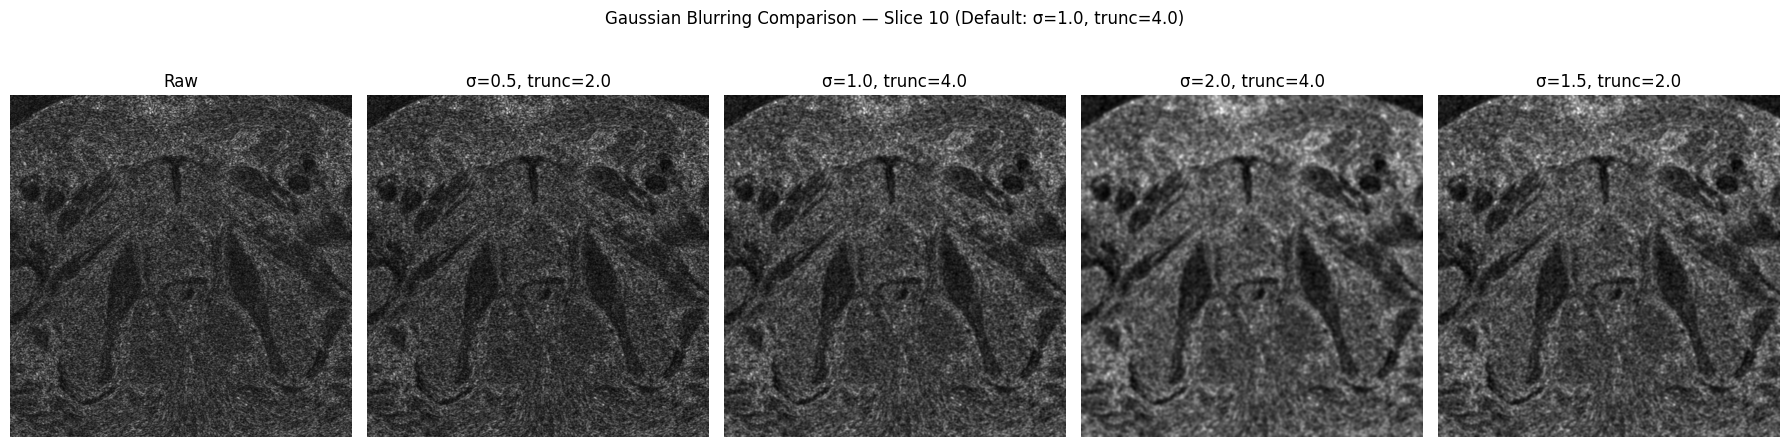

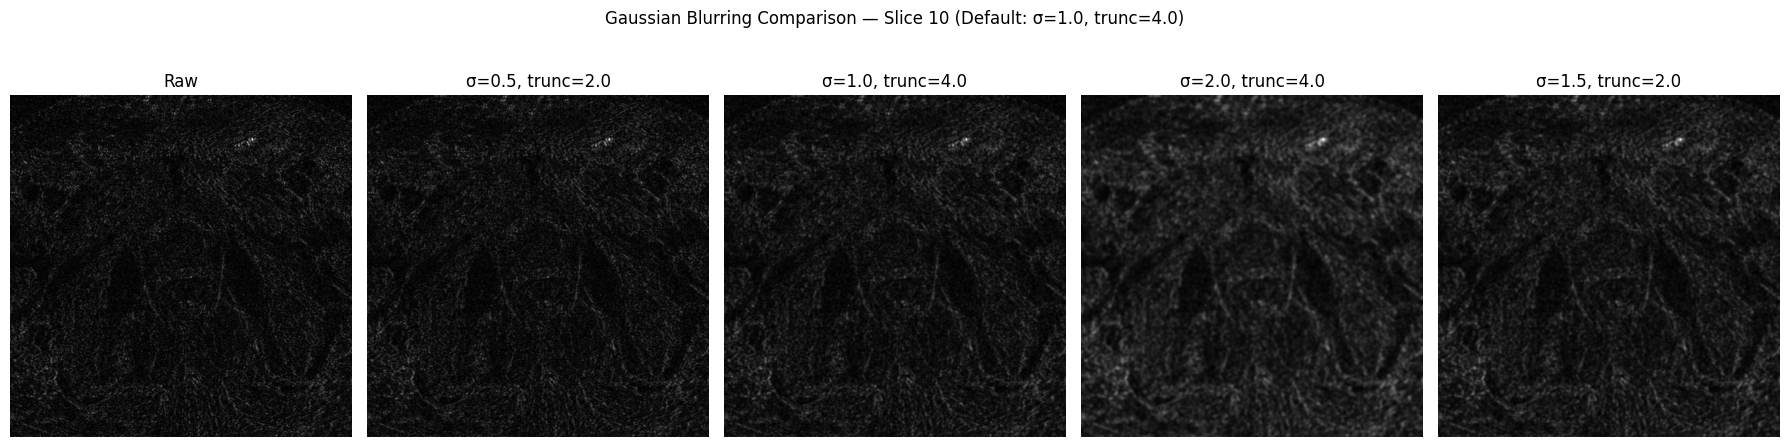

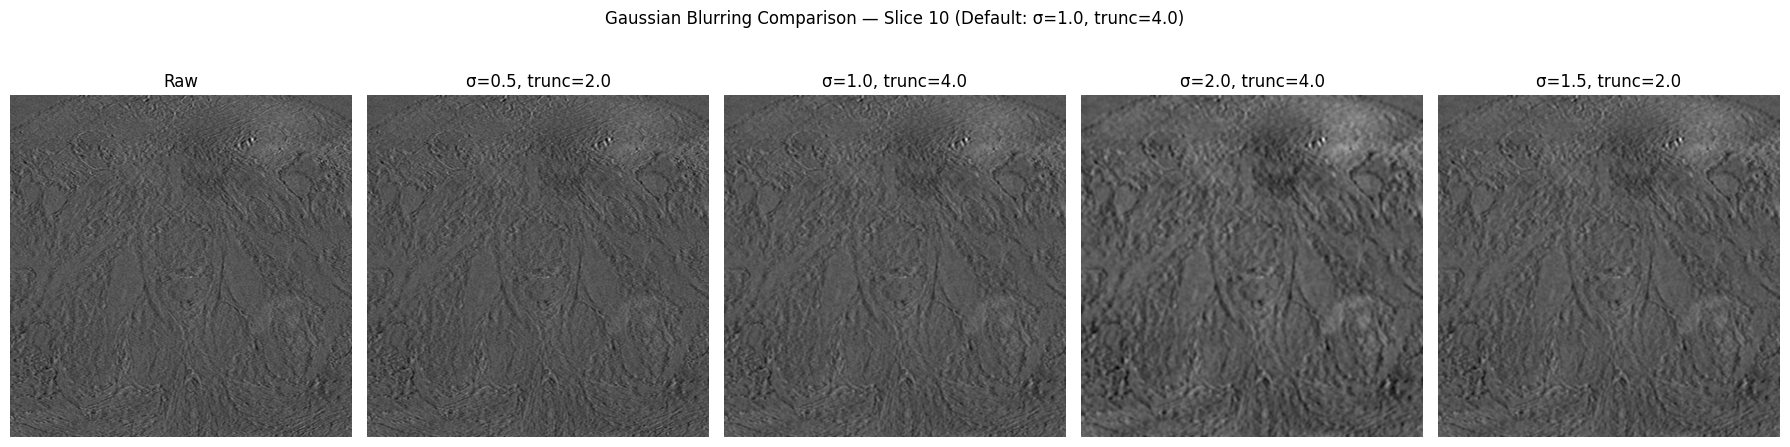

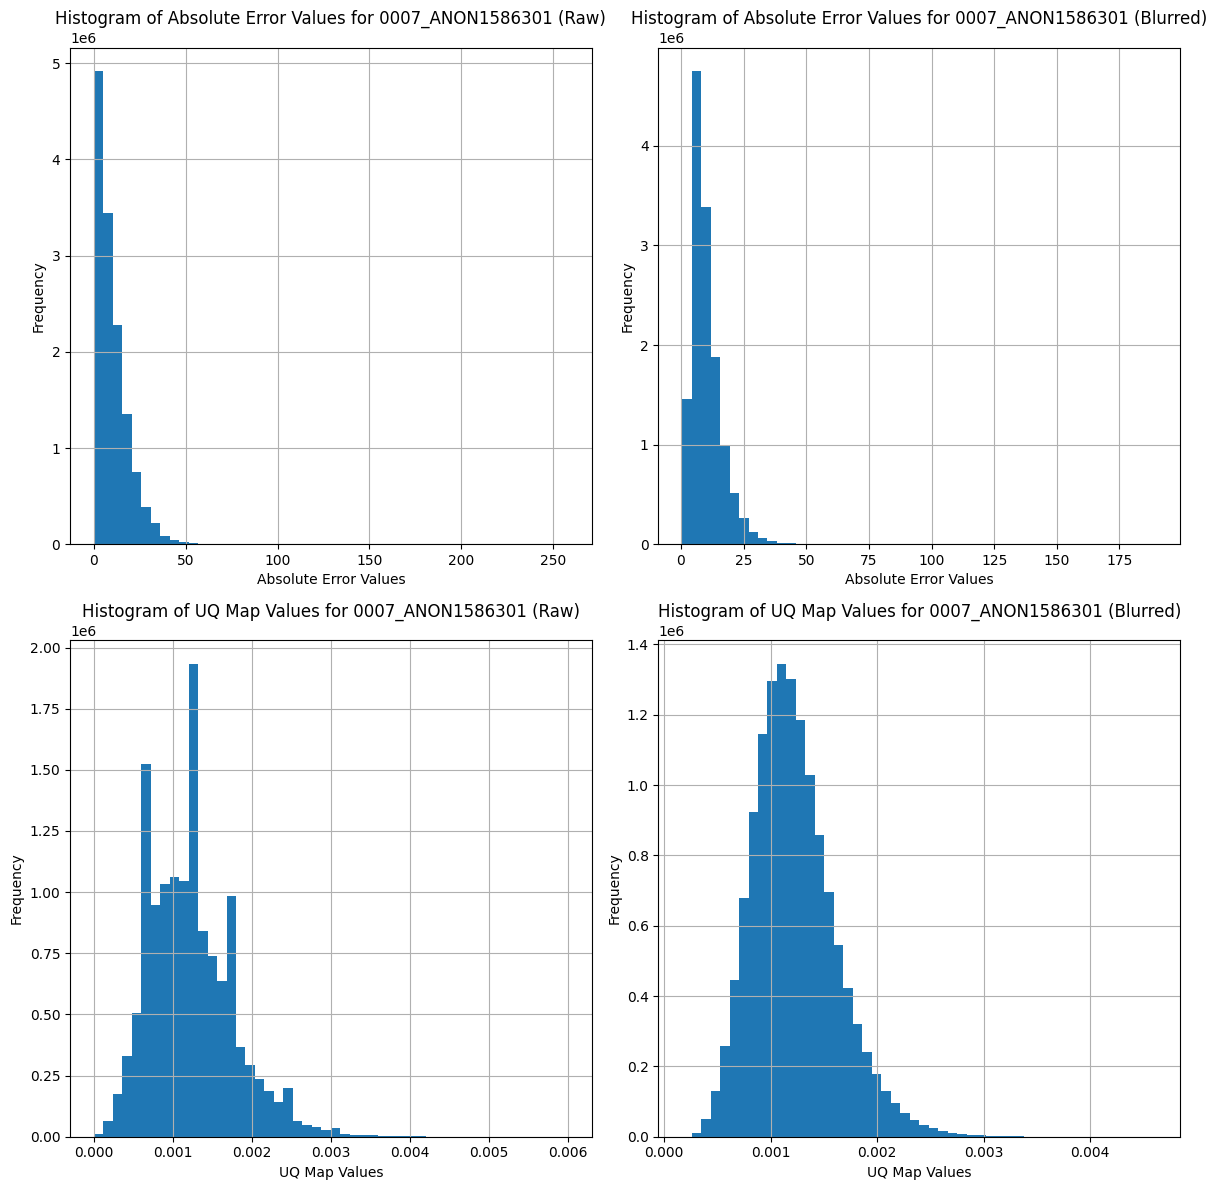

In [28]:
def compare_gaussian_blur_settings(volume: np.ndarray, slice_idx: int, sigma_z: float = 0.0):
    """
    Compare raw image and multiple Gaussian blur parameter settings on a single slice.

    Parameters:
        volume (np.ndarray): 3D volume (slices, H, W)
        slice_idx (int): Index of slice to visualize
        sigma_z (float): Fixed sigma for through-plane blurring (usually 0)

    Returns:
        None (displays figure)
    """
    from scipy.ndimage import gaussian_filter
    import matplotlib.pyplot as plt

    # Blur parameter settings: (sigma_xy, truncate)
    settings = [
        ("Raw", None, None),
        ("σ=0.5, trunc=2.0", 0.5, 2.0),
        ("σ=1.0, trunc=4.0", 1.0, 4.0),  # Default
        ("σ=2.0, trunc=4.0", 2.0, 4.0),
        ("σ=1.5, trunc=2.0", 1.5, 2.0),
    ]

    fig, axs = plt.subplots(1, len(settings), figsize=(18, 5))
    for i, (label, sigma_xy, truncate) in enumerate(settings):
        if sigma_xy is None:
            img = volume[slice_idx]
        else:
            img = gaussian_filter(volume, sigma=(sigma_z, sigma_xy, sigma_xy), truncate=truncate)[slice_idx]
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.suptitle(f"Gaussian Blurring Comparison — Slice {slice_idx} (Default: σ=1.0, trunc=4.0)")
    plt.tight_layout()
    plt.show()



pat_id   = '0007_ANON1586301'
idx      = 10
pat_root = roots['reader_study'] / pat_id

# R1 Loading
r1_img            = sitk.ReadImage(str(pat_root / f"{pat_id}_rss_target_dcml.mha"))
r1_arr            = sitk.GetArrayFromImage(r1_img)

# R3 Loading Base
r6_arr            = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R6_recon_dcml.mha")))

# Abs error
r6_abs_error_arr  = np.abs(r1_arr - r6_arr)
r6_abs_error_blu_arr = apply_gaussian_blur_3d(r6_abs_error_arr, sigma_xy=1.0, sigma_z=0.0)
r6_error_arr      = r1_arr - r6_arr
r6_error_blu_arr = apply_gaussian_blur_3d(r6_error_arr, sigma_xy=1.0, sigma_z=0.0)

# Uncertainty Quantification Map
r6_uq_map_arr     = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_gaussian"] / pat_id / f"uq_map_R6_gm25.nii.gz")))
r6_uq_map_blu_arr = apply_gaussian_blur_3d(r6_uq_map_arr, sigma_xy=1.0, sigma_z=0.0)

# Compare diffent Gaussian blur settings
compare_gaussian_blur_settings(r6_uq_map_arr, slice_idx=idx)
compare_gaussian_blur_settings(r6_abs_error_arr, slice_idx=idx)
compare_gaussian_blur_settings(r6_error_arr, slice_idx=idx)

# lets make 4 histograms, first row 2 histograms of the abs error map hist raw and blurred, second row 2 histograms of the uq map hist raw and blurred
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].hist(r6_abs_error_arr.flatten(), bins=50)
axs[0, 0].set_xlabel("Absolute Error Values")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_title(f"Histogram of Absolute Error Values for {pat_id} (Raw)")
axs[0, 0].grid()
axs[0, 1].hist(r6_abs_error_blu_arr.flatten(), bins=50)
axs[0, 1].set_xlabel("Absolute Error Values")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_title(f"Histogram of Absolute Error Values for {pat_id} (Blurred)")
axs[0, 1].grid()
axs[1, 0].hist(r6_uq_map_arr.flatten(), bins=50)
axs[1, 0].set_xlabel("UQ Map Values")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_title(f"Histogram of UQ Map Values for {pat_id} (Raw)")
axs[1, 0].grid()
axs[1, 1].hist(r6_uq_map_blu_arr.flatten(), bins=50)
axs[1, 1].set_xlabel("UQ Map Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title(f"Histogram of UQ Map Values for {pat_id} (Blurred)")
axs[1, 1].grid()
plt.tight_layout()
plt.show()
